In [2]:
# A check to see if environment variables are setup correctly:
import sys, math, random, ROOT, uproot, torch
import numpy as np

In [3]:
# now do stuff:
signal_file = ROOT.TFile("formatted/tau_signal.root")
signal_tree = signal_file.Get("signal")

background_file = ROOT.TFile("formatted/background.root")
background_tree = background_file.Get("background")

signal_entries = signal_tree.GetEntries()
background_entries = background_tree.GetEntries()
print(signal_entries)
print(background_entries)
#signal_tree.Print()

7812
69049


In [4]:
signal_layer_ets = []
background_layer_ets = []
all_layer_ets = []
all_truth = []

for i in range(signal_entries):
    signal_tree.GetEntry(i)
    layer_ets = [signal_tree.L0EM, signal_tree.L1EM, signal_tree.L2EM, signal_tree.L3EM, signal_tree.LHAD]
    layer_ets = [et / 1000. for et in layer_ets]
    
    signal_layer_ets.append(layer_ets)
    all_layer_ets.append(layer_ets)
    
    all_truth.append(1)
    
    
for i in range(background_entries):
    background_tree.GetEntry(i)
    layer_ets = [background_tree.L0EM, background_tree.L1EM, background_tree.L2EM, background_tree.L3EM, background_tree.LHAD]
    layer_ets = [et / 1000. for et in layer_ets]
    
    background_layer_ets.append(layer_ets)
    all_layer_ets.append(layer_ets)
    
    all_truth.append(0)

In [5]:
# Create a histogram of reconstructed Et of all signal and background events
h_signal = ROOT.TH1F("signal_recoEt", "signal_recoEt", 100, -20, 100)
h_signal.GetXaxis().SetTitle("Reconstructed Et")
h_signal.GetYaxis().SetTitle("Events")

h_background = ROOT.TH1F("background_recoEt", "background_recoEt", 100, -20, 100)
h_background.GetXaxis().SetTitle("Reconstructed Et")
h_background.GetYaxis().SetTitle("Events")

c = ROOT.TCanvas("c", "canvas", 400, 400)

In [6]:
h_signal.Reset()
for event in signal_layer_ets:
    h_signal.Fill(sum(event))
print(h_signal.GetEntries())
    
h_background.Reset()
for event in background_layer_ets:
    h_background.Fill(sum(event))
print(h_background.GetEntries())

7812.0
69049.0


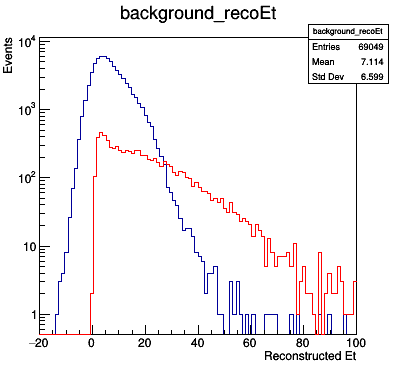

In [6]:
h_background.Draw()
h_signal.Draw('same')
h_signal.SetLineColor(2)
c.SetLogy()
c.Draw()

In [7]:
# Create data for initial ROC curves
signal_roc_counts = np.zeros(100)
background_roc_counts = np.zeros(100)

signal_roc_counts[0] += 1

for i, layers in enumerate(all_layer_ets):
    total_et = sum(layers)
    
    for j in range(100):
        if total_et > j:
            if all_truth[i] == 1:
                signal_roc_counts[j] += 1
            elif all_truth[i] == 0:
                background_roc_counts[j] += 1
            
# Convert event counts to efficiencies
signal_roc_eff = np.array([float(sig_count / signal_roc_counts[0]) for sig_count in signal_roc_counts])
background_roc_eff = np.array([float(back_count / background_roc_counts[0]) for back_count in background_roc_counts])

#signal_roc_eff = list(signal_roc_eff)
#background_roc_eff = list(background_roc_eff)

#print(signal_roc_counts)
#print(signal_roc_eff)
#print(background_roc_counts)
#print(background_roc_eff)

21675.13671875


Info in <TCanvas::Print>: pdf file nn_weights.pdf has been created


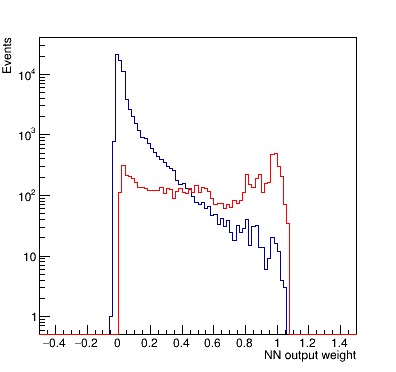

In [8]:
# cast all_data list to numpy array:
npArray_all_layer_ets = np.array(all_layer_ets)

# NN input vectors:
Xin = torch.from_numpy(np.dstack([
    npArray_all_layer_ets[:,0], 
    npArray_all_layer_ets[:,1], 
    npArray_all_layer_ets[:,2], 
    npArray_all_layer_ets[:,3],
    npArray_all_layer_ets[:,4]])[0].astype(np.float32)) 

# NN test value: 0=background, 1=signal
Yout = torch.from_numpy(np.array(all_truth).astype(np.float32).reshape(-1, 1))

# NN parameters:
neural_network = torch.nn.Sequential(    # the neural network topology:
    torch.nn.Linear(5, 8),               # input → hidden: 5 dimensions → 8 dimensions
    torch.nn.Sigmoid(),
    torch.nn.Linear(8, 8),               # non-linearity applied to each of the 5 components
    torch.nn.Sigmoid(),
    torch.nn.Linear(8, 1))               # hidden → output: 5 dimensions → 1 dimension

loss_fn = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.075)

# train the network:
for i in range(1000):                    # iterate 100 times to minimize loss: y_pred - y
    y_pred = neural_network(Xin)           # neural_network is a function: X ↦ y
    loss = loss_fn(y_pred, Yout)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 1:
        print(loss.item())
        
#torch.save(neural_network.state_dict(), "nn_state")
    
# check the NN output for event 0:    
h_nnOutputWeights_sig = ROOT.TH1F("nn_sig", "nn_sig", 100, -0.5, 1.5)
h_nnOutputWeights_sig.SetLineColor(ROOT.kRed)
h_nnOutputWeights_bkg = ROOT.TH1F("nn_bkg", "nn_bkg", 100, -0.5, 1.5)
h_nnOutputWeights_sig.GetXaxis().SetTitle("NN output weight")
h_nnOutputWeights_sig.GetYaxis().SetTitle("Events")
h_nnOutputWeights_bkg.GetXaxis().SetTitle("NN output weight")
h_nnOutputWeights_bkg.GetYaxis().SetTitle("Events")
h_nnOutputWeights_bkg.SetTitle("")
h_nnOutputWeights_sig.SetTitle("")

for i in range(len(Xin)):
    if Yout[i] == 1.0:
        h_nnOutputWeights_sig.Fill(neural_network(Xin[i]))
    else:
        h_nnOutputWeights_bkg.Fill(neural_network(Xin[i]))
    
c_nn = ROOT.TCanvas("c_nn", "c_nn", 400, 400)
ROOT.gStyle.SetOptStat(0)
h_nnOutputWeights_bkg.Draw()
h_nnOutputWeights_sig.Draw("same")
c_nn.SetLogy()
c_nn.Draw()

c_nn.SaveAs("nn_weights.pdf")

In [9]:
# Create data for network-trained ROC curves

# Run all training samples through the trained network
network_outputs = neural_network(Xin)

# Create arrays to hold the number of events left after each Et cut
signal_network_roc_counts = np.zeros(100)
background_network_roc_counts = np.zeros(100)

for i, value in enumerate(network_outputs):
    #total_et = sum(layers)
    if i == 0:
        print(value)
    
    for j in range(100):
        if value > (-0.2 + j*0.01):
            if all_truth[i] == 1:
                signal_network_roc_counts[j] += 1
            elif all_truth[i] == 0:
                background_network_roc_counts[j] += 1
            
# Convert event counts to efficiencies
signal_network_roc_eff = np.array([float(sig_count / signal_network_roc_counts[0]) for sig_count in signal_network_roc_counts])
background_network_roc_eff = np.array([float(back_count / background_network_roc_counts[0]) for back_count in background_network_roc_counts])

tensor([0.9769], grad_fn=<SelectBackward>)


In [16]:
# Read in BDT efficiency arrays from flat files
#signal_bdt_efficiencies = []
with open('bdt/bdt_sigeff.txt', 'r') as sig_file:
    signal_bdt_roc_eff = sig_file.readlines()
    
with open('bdt/bdt_bkgeff.txt', 'r') as back_file:
    background_bdt_roc_eff = back_file.readlines()

signal_bdt_roc_eff = np.array([float(value) for value in signal_bdt_roc_eff])
background_bdt_roc_eff = np.array([float(value) for value in background_bdt_roc_eff])


# Cheat and add 1.0/1.0 efficiency value to BDTs to make the ROC curves look good
signal_bdt_roc_eff = np.insert(signal_bdt_roc_eff, 0, 1)
background_bdt_roc_eff = np.insert(background_bdt_roc_eff, 0, 1)

#print(signal_bdt_roc_eff)
#print(background_bdt_roc_eff)

[1.       0.99936  0.996799 0.996159 0.995519 0.995519 0.993598 0.992958
 0.992958 0.992318 0.991677 0.991037 0.991037 0.988476 0.987196 0.986556
 0.984635 0.983995 0.982074 0.982074 0.982074 0.980794 0.980794 0.980154
 0.979513 0.978873 0.977593 0.976312 0.973752 0.973111 0.972471 0.971831
 0.970551 0.970551 0.96927  0.96735  0.966709 0.966069 0.963508 0.960948
 0.960307 0.959027 0.959027 0.958387 0.957746 0.956466 0.955826 0.955186
 0.953905 0.952625 0.951985 0.951344 0.948784 0.946223 0.944942 0.942382
 0.941101 0.939821 0.93854  0.9379   0.93662  0.935339 0.935339 0.932778
 0.930858 0.928937 0.925096 0.923816 0.920615 0.918694 0.915493 0.910371
 0.908451 0.90717  0.90525  0.903329 0.898207 0.895647 0.889885 0.886684
 0.881562 0.879001 0.87644  0.870038 0.865557 0.861716 0.854673 0.850192
 0.84443  0.839309 0.833547 0.823303 0.8137   0.802177 0.784891 0.766325
 0.739437 0.705506 0.654289 0.552497]
[1.00000e+00 2.73952e-01 2.36875e-01 2.12470e-01 1.92990e-01 1.75827e-01
 1.63589e-01 

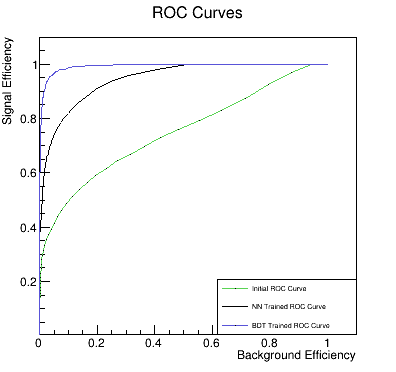

In [21]:
# Plot ROC curves, should make the Y axis linear
initial_roc_curve = ROOT.TGraph(100, background_roc_eff, signal_roc_eff)
network_roc_curve = ROOT.TGraph(100, background_network_roc_eff, signal_network_roc_eff)
bdt_roc_curve = ROOT.TGraph(101, background_bdt_roc_eff, signal_bdt_roc_eff)
c.Clear()
initial_roc_curve.Draw()
initial_roc_curve.SetTitle('ROC Curves')
initial_roc_curve.SetLineColor(8)
initial_roc_curve.GetXaxis().SetTitle('Background Efficiency')
initial_roc_curve.GetYaxis().SetTitle('Signal Efficiency')

network_roc_curve.Draw('l')
network_roc_curve.SetLineColor(1)

bdt_roc_curve.Draw('l')
bdt_roc_curve.SetLineColor(9)

legend = ROOT.TLegend(.55, .1, .9, .25)
legend.AddEntry(initial_roc_curve, 'Initial ROC Curve')
legend.AddEntry(network_roc_curve, 'NN Trained ROC Curve')
legend.AddEntry(bdt_roc_curve, 'BDT Trained ROC Curve')

legend.Draw()

c.Draw()